<a href="https://colab.research.google.com/github/velozo27/TCC-Pedro-Velozo-ENG1132/blob/change-how-image-files-are-retrieved/SRCNN_Comentada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports e definição de Constantes

In [1]:
try:
    from google.colab import files
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATASET_ROOT="/content/gdrive/MyDrive/TCC/datasets"
    !pip install patchify
    # wandb to log system metrics: (check CPU and GPU usage while session is runnig)
    !pip install wandb
    import wandb
    wandb.init()
    
    import save_model_helper

except ModuleNotFoundError:
    DATASET_ROOT="./datasets/"
    # coloquei as dependencias em um arquivo separado
    !pip install -r requirements.txt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize
import pandas as pd
import time
import re
from pathlib import Path
import image_patches
import image_helper
import load_model_helper


DATASET_NAME = "Flickr2K"
# DATASET_NAME = "Set14"

# Mudar aqui se for para treinar salvando os dataframes e epochs no drive
# Se True, não pega nem salva nada no drive
EXPERIMENTAL_MODE = True


# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
# garantir que é cuda
assert device == "cuda"

# https://stackoverflow.com/questions/65734044/kernel-appears-to-have-died-jupyter-notebook-python-matplotlib
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Criando os patches

(patches já foram criados, não precisa rodar)

In [2]:
%time
# otimizacao: criar patches de treino, validacao e teste de uma vez: (32, 8, 2)
# image_patches.create_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_train", 32)
# image_patches.create_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_validation", 8)

CPU times: total: 0 ns
Wall time: 0 ns


# ***SRCNN***

In [3]:
class SRCNN(nn.Module):
    def __init__(self, initialization="normal") -> None:
        super(SRCNN, self).__init__()
        # 4.3 Model and Performance Trade-offs
        # Based on the basic network settings (i.e., f1 = 9, f2 = 1, f3 = 5, n1 = 64, and n2 = 32),
        f1 = 9
        f2 = 1
        f3 = 5
#       n1 = 64
        n1 = 3
        n2 = 32

        self.initialization = initialization

        self.model = nn.Sequential(
            # 3.1.1 Patch extraction and representation
            nn.Conv2d(in_channels=3, out_channels=n1,
#                       kernel_size=(f1, f1), padding=(f1-1)//2), # TODO: ver como ficar sem o padding
                      kernel_size=(f1, f1), padding=0,),
            nn.ReLU(),

            # # 3.1.2 Non-linear mapping
#             nn.Conv2d(in_channels=n1, out_channels=n2,
#                       kernel_size=(f2, f2), padding=(f2-1)//2),
#             #           kernel_size=(f2, f2), padding=0,),
#             nn.ReLU(),

#             # # 3.1.3 Reconstruction
#             nn.Conv2d(in_channels=n2, out_channels=3,
#                       kernel_size=(f3, f3), padding=(f3-1)//2),
            #           kernel_size=(f3, f3), padding=0),
        )

        self._init_weights()

    def _init_weights(self):
      # The filter weights of each layer are initialized by drawing randomly 
      # from a Gaussian distribution with zero mean and standard deviation 0.001 (and 0 for biases)
      for module in self.modules():
        if isinstance(module, nn.Conv2d):
          if self.initialization == "normal":
            module.weight.data.normal_(mean=0.0, std=0.001)
          elif self.initialization == "xavier":
            nn.init.xavier_normal_(module.weight.data)
          else:
            nn.init.eye_(module.weight.data)

          if module.bias is not None:
              module.bias.data.zero_()

    def print_weights(self):
      for module in self.modules():
       if isinstance(module, nn.Conv2d):
          print(module.weight)

    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x


# Loops de **Treino** e **Validação**

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    print(f"Training on {size} samples...")
    print("Batch size:", dataloader.batch_size)
    print("Number of batches:", num_batches)

    train_loss = 0
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        #print("X", X.shape, X.get_device())
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= num_batches

    # return avg loss
    print(f"Training Error: \n Avg loss: {train_loss:>8f} \n")
    return train_loss

# will also be used for testing (maybe)
def validation_loop(dataloader, model, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0

    with torch.no_grad(), tqdm(total=num_batches) as progress_bar:
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            progress_bar.update(1)

    validation_loss /= num_batches

    print(f"Validation Error: \n Avg loss: {validation_loss:>8f} \n")
    return validation_loss


# CustomImageDataset

In [5]:
class CustomImageDataset(Dataset):
    """
    A PyTorch dataset for loading a directory of images.

    Args:
        img_dir (str): The path to the directory containing the images.
        transform (callable, optional): A function/transform that takes in an image and returns a
            transformed version. Default: None.
        target_transform (callable, optional): A function/transform that takes in the target and
            transforms it. Default: None.
    """

    def __init__(self, img_dir: str, patches_per_image = None | int, transform = None, target_transform = None, use_patches = True, device="cuda" if torch.cuda.is_available() else "cpu" ):
        """
        Initializes a new instance of the CustomImageDataset class.

        Args:
            img_dir (str): The path to the directory containing the images.
            transform (callable, optional): A function/transform that takes in an image and returns a
                transformed version. Default: None.
            target_transform (callable, optional): A function/transform that takes in the target and
                transforms it. Default: None.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.patches_per_image = patches_per_image
        
        self.file_list_tensor = self.create_tensors_from_images()
        self.file_list_tensor.to(device)

    def create_tensors_from_images(self):
      number_of_images = self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

      # creating the empty tensor
      image_tensors = torch.empty((number_of_images, 3, 33, 33))

      current_tensor_index = 0

      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      for patch_path in tqdm(list(os.listdir(all_patches_dir))):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue
          
          image_as_tensor = read_image(f"{self.img_dir}/{image_path}")

          # updating the created tensor
          image_tensors[current_tensor_index] = image_as_tensor.float() / 255

          current_tensor_index += 1
                    
      return image_tensors


    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            The number of images in the dataset.
        """
        return self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the image at the specified index in the dataset.

        Args:
            idx (int): The index of the image to return.

        Returns:
            A tuple containing the transformed input image and the transformed target image.
        """
    
        image = self.file_list_tensor[idx]
        image_x = image.detach().clone()
        image_y = image.detach().clone()

        if self.transform:
            image_x = self.transform(image_x)
        if self.target_transform:
            image_y = self.target_transform(image_y)

        return image_x, image_y

    def _get_number_of_images_in_folder(self, dir: str):
      """
      Gets the total number of all the patches
      """
      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      number_of_images = 0
      for patch_path in list(os.listdir(all_patches_dir)):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue

          number_of_images += 1

      return number_of_images

    def _check_if_image_is_not_corrupted(self, image_path: str) -> bool:
      """
      Returns True if the file is corrupted else returns False
      """
      file_size = Path(f"{self.img_dir}/{image_path}").stat().st_size

      if file_size == 0:
        print(f"Error loading image file: {self.img_dir}/{image_path}. Reason: file has size 0")
        return True
      
      return False

# Criando os ***Dataset*'s**

In [6]:
%%time
transform_x = transforms.Compose([
    # downscale by factor of 3 (from 33x33 to 11x11 back to 33x33)
    # resize image to 11x11 and downsample by BICUBIC interpolation
#     transforms.Resize((11, 11), interpolation=Image.BICUBIC),
    # resize image to 33x33
#     transforms.Resize((33, 33), interpolation=Image.BICUBIC)
#     transforms.CenterCrop((33, 33))
])

transform_y = transforms.Compose([
    ##transforms.Resize((33, 33), interpolation=Image.BICUBIC)
    ##transforms.CenterCrop((21, 21))
    transforms.CenterCrop((25, 25))
#     transforms.CenterCrop((33, 33))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_train", transform=transform_x, target_transform=transform_y)
validation_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_validation", transform=transform_x, target_transform=transform_y)

# # Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

100%|█████████████████████████████████████████████████████████████████████████████| 2650/2650 [00:17<00:00, 147.93it/s]


Training set has 84800 instances
Validation set has 21200 instances
CPU times: total: 17.1 s
Wall time: 3min 1s


In [7]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = True
batch_size = round(1.5 * (2**12))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory) # TODO: aumentar batch_size p/ 2^12
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: total: 5.58 s
Wall time: 1min 44s


# Instanciando o modelo

In [8]:
# Instancianting the model
# Atencao: cuidado ao rodar o treino várias vezes sem resetar o modelo!
model = SRCNN(initialization="normal")
model.to(device)

# hyperparameters
#https://stackoverflow.com/questions/48324152/pytorch-how-to-change-the-learning-rate-of-an-optimizer-at-any-given-moment-no
lr = 1e-3

In [9]:
img = image_patches.get_image_patch(f"{DATASET_ROOT}/{DATASET_NAME}_train").float()/255
print(type(img), img.shape, img.dtype, img.min(), img.max())
with torch.no_grad():
  img_out = model(img.unsqueeze(0).to(device))
print(type(img_out), img_out.shape, img_out.dtype, img_out.min(), img_out.max())
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(ImageHelperInstance.tensor_as_image(img.cpu()))
# plt.subplot(1, 2, 2)
# plt.imshow(ImageHelperInstance.tensor_as_image(img_out.squeeze().cpu()))
# plt.show()

./datasets//Flickr2K_train\patches
./datasets//Flickr2K_train\patches\000786_patch
<class 'torch.Tensor'> torch.Size([3, 33, 33]) torch.float32 tensor(0.0549) tensor(0.5608)
<class 'torch.Tensor'> torch.Size([1, 3, 25, 25]) torch.float32 tensor(0., device='cuda:0') tensor(0.0057, device='cuda:0')


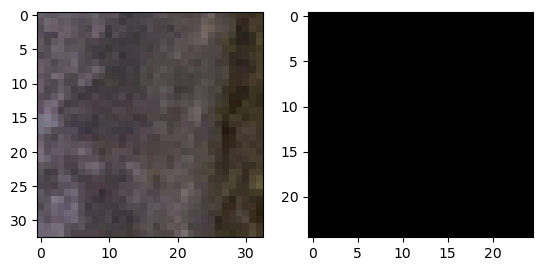

In [10]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image_helper.tensor_as_image(img.cpu()))
plt.subplot(1, 2, 2)
plt.imshow(image_helper.tensor_as_image(img_out.squeeze().cpu()))
plt.show()

# Criando o *Optmizer* e a *loss function* (MSE)

In [11]:
# otimizacao: Mudar o otimizador para Adam ou RMSProp
#           : Usar momentum = 0.9
#           : Usar learning maior: 1e-4?
#           : Usar learning rate decay

# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()
loss_fn.to(device)

MSELoss()

# Exemplos de imagem de baixa e alta resolução do dataset de treino

<class 'torch.Tensor'> torch.Size([6144, 3, 33, 33]) torch.float32 tensor(0.) tensor(1.)
<class 'torch.Tensor'> torch.Size([6144, 3, 25, 25]) torch.float32 tensor(0.) tensor(1.)
<class 'torch.Tensor'> torch.Size([6144, 3, 33, 33]) torch.float32 tensor(0.) tensor(1.)
<class 'torch.Tensor'> torch.Size([6144, 3, 25, 25]) torch.float32 tensor(0.) tensor(1.)


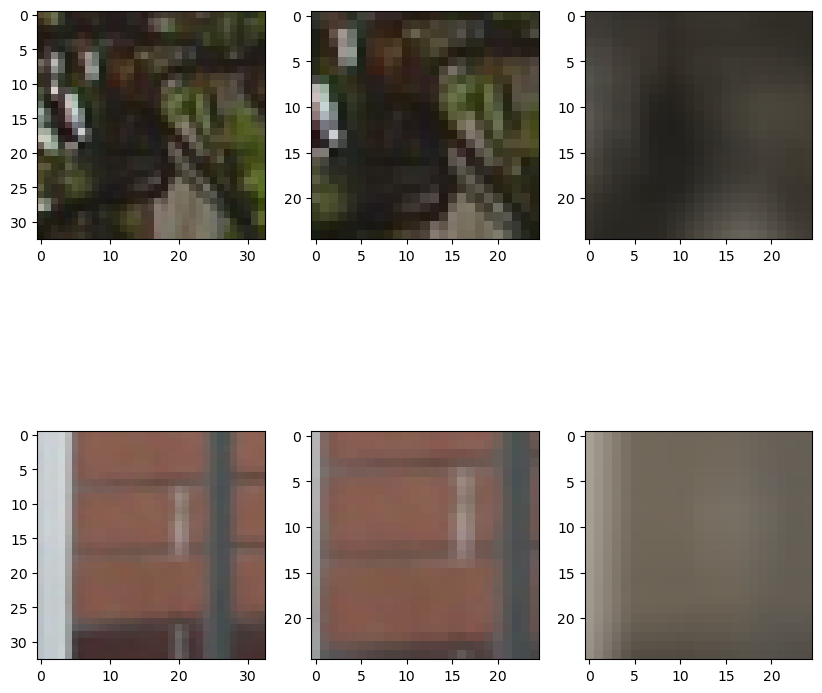

In [26]:
# example of training image
num_samples = 2
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))
for i, (X, y) in enumerate(train_dataloader):
    with torch.no_grad():
        z = model.forward(X.to(device))
    print(type(X), X.shape, X.dtype, X.min(), X.max())
    print(type(y), y.shape, y.dtype, y.min(), y.max())
    axes[i, 0].imshow(image_helper.tensor_as_image(X[0]))
    axes[i, 1].imshow(image_helper.tensor_as_image(y[0]))
    axes[i, 2].imshow(image_helper.tensor_as_image(z[0].cpu()))
    # axes[i, 0].set_axis_off()
    if i == num_samples - 1:
        break
plt.show()

# Carregando o modelo

## Carregando a última *epoch* executada

In [13]:
# most_recent_epoch, model_load_path_name = load_model_helper.get_most_recent_epoch(directory = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/models')

# print("Most recent epoch:", most_recent_epoch)
# print("Model load path name:", model_load_path_name)

model_load_path_name = ''

In [14]:
# model = load_model_helper.load_state_dict(model, model_load_path_name)

# **Treinamento** 

## Execução das *epochs*
- Execução dos loops de treinamento e validação, e também salvamentos dos dados

In [15]:
starting_epoch = load_model_helper.get_epoch_number_from_path(model_load_path_name)
if starting_epoch is not None:
  starting_epoch = starting_epoch + 1 # add 1 because we are starting after the epoch we left of

print('starting_epoch =', starting_epoch)

starting_epoch = None


In [16]:
%%time
train_loss = 0
validation_loss = 0
epochs = 50

######
epoch_array = []
time_array = []
lr_array = []
######

# melhor usar lista e depois converter para array
train_loss_array = list()
validation_loss_array = list()
for index, t in enumerate(range(epochs)):
    current_epoch = load_model_helper.get_current_epoch(index, t, starting_epoch)
    
    print(f"\nepoch {current_epoch}\n-------------------------------")

    start_time = time.time()  # Start timing the epoch

    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    validation_loss = validation_loop(validation_dataloader, model, loss_fn)
    
    train_loss_array.append(train_loss)
    validation_loss_array.append(validation_loss)

    elapsed_time = time.time() - start_time  # Calculate elapsed time for the epoch
    
    ######
    epoch_array.append(current_epoch)
    time_array.append(elapsed_time)
    lr_array.append(optimizer.param_groups[0]['lr'])
    ######
    
    # updating learning rate
    if current_epoch % 10 == 0 and current_epoch > 0:
        optimizer.param_groups[0]['lr'] /= 2

    if not EXPERIMENTAL_MODE:
      df_path = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/SRCNN_train_vs_validation_loss.csv'
      save_model_helper.save_df(df_path, train_loss, validation_loss, current_epoch, elapsed_time)
      save_model_helper.save_epoch(current_epoch, train_loss, validation_loss)
    
print("Done!")


epoch 0
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:15<00:00,  5.40s/it]


Training Error: 
 Avg loss: 0.185878 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.43s/it]


Validation Error: 
 Avg loss: 0.101515 


epoch 1
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:32<00:00,  2.29s/it]


Training Error: 
 Avg loss: 0.066855 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.04s/it]


Validation Error: 
 Avg loss: 0.040062 


epoch 2
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.17s/it]


Training Error: 
 Avg loss: 0.029598 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.23s/it]


Validation Error: 
 Avg loss: 0.021360 


epoch 3
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.08s/it]


Training Error: 
 Avg loss: 0.018182 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.25s/it]


Validation Error: 
 Avg loss: 0.015557 


epoch 4
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:32<00:00,  2.32s/it]


Training Error: 
 Avg loss: 0.014592 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.01s/it]


Validation Error: 
 Avg loss: 0.013647 


epoch 5
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.22s/it]


Training Error: 
 Avg loss: 0.013336 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.07s/it]


Validation Error: 
 Avg loss: 0.012917 


epoch 6
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.22s/it]


Training Error: 
 Avg loss: 0.012813 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.03it/s]


Validation Error: 
 Avg loss: 0.012548 


epoch 7
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.43s/it]


Training Error: 
 Avg loss: 0.012496 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.02it/s]


Validation Error: 
 Avg loss: 0.012292 


epoch 8
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.29s/it]


Training Error: 
 Avg loss: 0.012253 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


Validation Error: 
 Avg loss: 0.012075 


epoch 9
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:32<00:00,  2.33s/it]


Training Error: 
 Avg loss: 0.012044 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


Validation Error: 
 Avg loss: 0.011874 


epoch 10
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:32<00:00,  2.33s/it]


Training Error: 
 Avg loss: 0.011845 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


Validation Error: 
 Avg loss: 0.011682 


epoch 11
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.15s/it]


Training Error: 
 Avg loss: 0.011699 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.02s/it]


Validation Error: 
 Avg loss: 0.011588 


epoch 12
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.38s/it]


Training Error: 
 Avg loss: 0.011604 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.04s/it]


Validation Error: 
 Avg loss: 0.011497 


epoch 13
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.08s/it]


Training Error: 
 Avg loss: 0.011512 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


Validation Error: 
 Avg loss: 0.011407 


epoch 14
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.23s/it]


Training Error: 
 Avg loss: 0.011420 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


Validation Error: 
 Avg loss: 0.011318 


epoch 15
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.15s/it]


Training Error: 
 Avg loss: 0.011331 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.03it/s]


Validation Error: 
 Avg loss: 0.011230 


epoch 16
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:32<00:00,  2.30s/it]


Training Error: 
 Avg loss: 0.011246 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


Validation Error: 
 Avg loss: 0.011144 


epoch 17
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:28<00:00,  2.06s/it]


Training Error: 
 Avg loss: 0.011156 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.02s/it]


Validation Error: 
 Avg loss: 0.011060 


epoch 18
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.18s/it]


Training Error: 
 Avg loss: 0.011070 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.01it/s]


Validation Error: 
 Avg loss: 0.010977 


epoch 19
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.39s/it]


Training Error: 
 Avg loss: 0.010987 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.12s/it]


Validation Error: 
 Avg loss: 0.010895 


epoch 20
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.17s/it]


Training Error: 
 Avg loss: 0.010901 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.09s/it]


Validation Error: 
 Avg loss: 0.010814 


epoch 21
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.19s/it]


Training Error: 
 Avg loss: 0.010841 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.18s/it]


Validation Error: 
 Avg loss: 0.010774 


epoch 22
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.17s/it]


Training Error: 
 Avg loss: 0.010797 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.07s/it]


Validation Error: 
 Avg loss: 0.010734 


epoch 23
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.17s/it]


Training Error: 
 Avg loss: 0.010757 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.11s/it]


Validation Error: 
 Avg loss: 0.010695 


epoch 24
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.23s/it]


Training Error: 
 Avg loss: 0.010719 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it]


Validation Error: 
 Avg loss: 0.010656 


epoch 25
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.17s/it]


Training Error: 
 Avg loss: 0.010678 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it]


Validation Error: 
 Avg loss: 0.010618 


epoch 26
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:13<00:00,  5.22s/it]


Training Error: 
 Avg loss: 0.010634 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/it]


Validation Error: 
 Avg loss: 0.010579 


epoch 27
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:27<00:00,  2.00s/it]


Training Error: 
 Avg loss: 0.010597 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.02it/s]


Validation Error: 
 Avg loss: 0.010541 


epoch 28
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:27<00:00,  2.00s/it]


Training Error: 
 Avg loss: 0.010560 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


Validation Error: 
 Avg loss: 0.010504 


epoch 29
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:27<00:00,  2.00s/it]


Training Error: 
 Avg loss: 0.010524 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


Validation Error: 
 Avg loss: 0.010466 


epoch 30
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.23s/it]


Training Error: 
 Avg loss: 0.010484 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


Validation Error: 
 Avg loss: 0.010429 


epoch 31
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.24s/it]


Training Error: 
 Avg loss: 0.010454 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.00it/s]


Validation Error: 
 Avg loss: 0.010411 


epoch 32
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:28<00:00,  2.02s/it]


Training Error: 
 Avg loss: 0.010438 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.19s/it]


Validation Error: 
 Avg loss: 0.010392 


epoch 33
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:28<00:00,  2.03s/it]


Training Error: 
 Avg loss: 0.010415 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.00it/s]


Validation Error: 
 Avg loss: 0.010374 


epoch 34
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:27<00:00,  2.00s/it]


Training Error: 
 Avg loss: 0.010400 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.06s/it]


Validation Error: 
 Avg loss: 0.010356 


epoch 35
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:28<00:00,  2.01s/it]


Training Error: 
 Avg loss: 0.010376 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


Validation Error: 
 Avg loss: 0.010337 


epoch 36
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:27<00:00,  1.99s/it]


Training Error: 
 Avg loss: 0.010359 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.01it/s]


Validation Error: 
 Avg loss: 0.010319 


epoch 37
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:28<00:00,  2.06s/it]


Training Error: 
 Avg loss: 0.010339 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


Validation Error: 
 Avg loss: 0.010301 


epoch 38
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:27<00:00,  2.00s/it]


Training Error: 
 Avg loss: 0.010325 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


Validation Error: 
 Avg loss: 0.010283 


epoch 39
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.21s/it]


Training Error: 
 Avg loss: 0.010304 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.03it/s]


Validation Error: 
 Avg loss: 0.010265 


epoch 40
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.08s/it]


Training Error: 
 Avg loss: 0.010291 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


Validation Error: 
 Avg loss: 0.010248 


epoch 41
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:32<00:00,  2.31s/it]


Training Error: 
 Avg loss: 0.010272 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


Validation Error: 
 Avg loss: 0.010239 


epoch 42
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.08s/it]


Training Error: 
 Avg loss: 0.010263 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.00s/it]


Validation Error: 
 Avg loss: 0.010230 


epoch 43
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:28<00:00,  2.01s/it]


Training Error: 
 Avg loss: 0.010250 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


Validation Error: 
 Avg loss: 0.010221 


epoch 44
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.27s/it]


Training Error: 
 Avg loss: 0.010243 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.01it/s]


Validation Error: 
 Avg loss: 0.010212 


epoch 45
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.21s/it]


Training Error: 
 Avg loss: 0.010240 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


Validation Error: 
 Avg loss: 0.010203 


epoch 46
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.21s/it]


Training Error: 
 Avg loss: 0.010229 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


Validation Error: 
 Avg loss: 0.010195 


epoch 47
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.15s/it]


Training Error: 
 Avg loss: 0.010218 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.06s/it]


Validation Error: 
 Avg loss: 0.010186 


epoch 48
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:28<00:00,  2.03s/it]


Training Error: 
 Avg loss: 0.010207 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.21s/it]


Validation Error: 
 Avg loss: 0.010177 


epoch 49
-------------------------------
Training on 84800 samples...
Batch size: 6144
Number of batches: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:28<00:00,  2.04s/it]


Training Error: 
 Avg loss: 0.010199 



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.00it/s]

Validation Error: 
 Avg loss: 0.010168 

Done!
CPU times: total: 42min 51s
Wall time: 51min 52s


# Train x Validation Loss

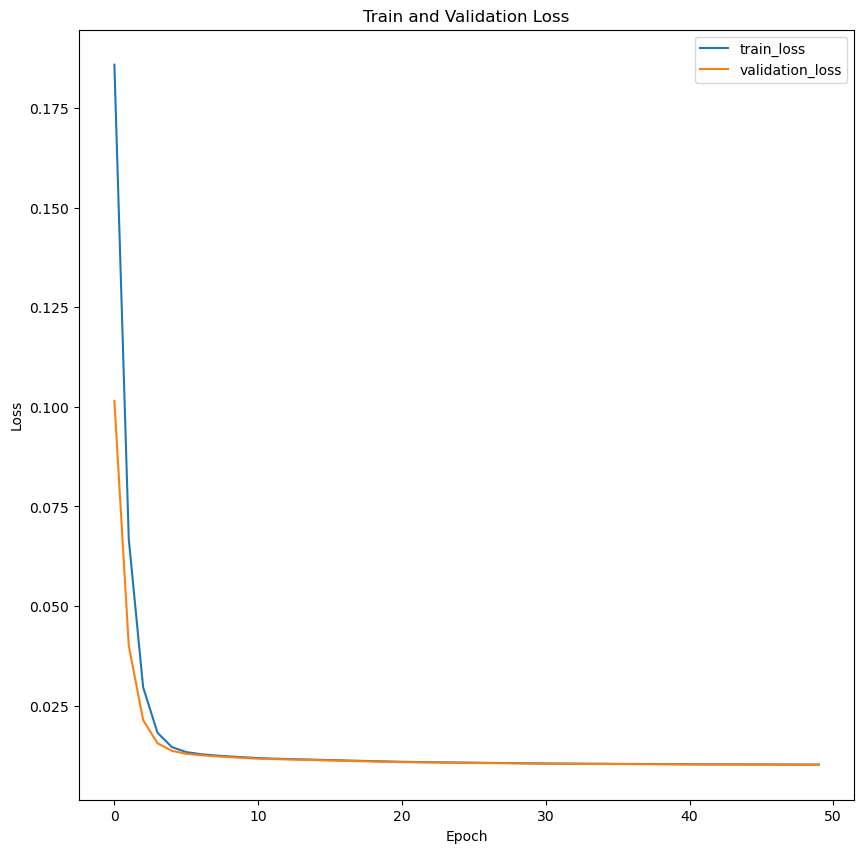

In [22]:
train_loss_array = np.array(train_loss_array)
validation_loss_array = np.array(validation_loss_array)

plt.figure(figsize=(10, 10))
plt.plot(range(len(train_loss_array)), train_loss_array, label='train_loss')
plt.plot(range(len(validation_loss_array)), validation_loss_array, label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [23]:
df = pd.DataFrame({'Train Loss': train_loss_array, 'Validation Loss': validation_loss_array, 'epoch': epoch_array, 'learning rate': lr_array, 'epoch_duration [s]': time_array})
df.head()

,Train Loss,Validation Loss,epoch,epoch_duration [s]
0,0.185878,0.101515,0,106.761646
1,0.066855,0.040062,1,59.989332
2,0.029598,0.021360,2,59.387819
3,0.018182,0.015557,3,60.032721
4,0.014592,0.013647,4,60.101066


In [24]:
df

,Train Loss,Validation Loss,epoch,epoch_duration [s]
0,0.185878,0.101515,0,106.761646
1,0.066855,0.040062,1,59.989332
2,0.029598,0.021360,2,59.387819
3,0.018182,0.015557,3,60.032721
4,0.014592,0.013647,4,60.101066
5,0.013336,0.012917,5,61.932205
6,0.012813,0.012548,6,60.030663
7,0.012496,0.012292,7,61.640065
8,0.012253,0.012075,8,60.825008
9,0.012044,0.011874,9,61.497246


# Tesntando o modelo em uma imagem

C:\Users\Pedro\AppData\Local\Temp\ipykernel_7388\1583506645.py:5: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((128, 128), interpolation=Image.LINEAR),
C:\Users\Pedro\AppData\Local\Temp\ipykernel_7388\1583506645.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((256, 256), interpolation=Image.LINEAR)
C:\Users\Pedro\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL)

torch.Size([3, 256, 256])
246


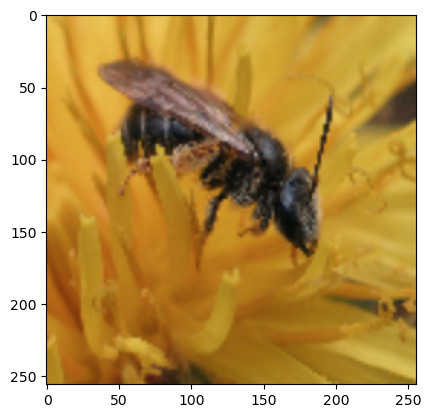

In [20]:
new_image = Image.open(f"{DATASET_ROOT}/Flickr2K/000797.png")
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((128, 128), interpolation=Image.LINEAR),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.LINEAR)
])


new_image_lr = transform(new_image)
print(new_image_lr.shape)
print(np.array(new_image).max())
image_helper.show_tensor_as_image(new_image_lr) # mudar pro arquivo novo


In [21]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr_np = new_image_sr.cpu().detach().numpy()
new_img = torch.mul(new_image_sr, 3)
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()

NameError: name 'new_image_sr' is not defined

<Figure size 640x480 with 0 Axes>